In [1]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import mayavi
import mayavi.mlab
import string
import subprocess
import functools
import cv2
#on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
mayavi.mlab.options.offscreen = True



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
def import_shit():
    import local_models.local_models
    import local_models.algorithms
    import local_models.utils
    import local_models.linear_projections
    import local_models.loggin
    import local_models.TLS_models
    import numpy as np
    import logging
    import string
    import ml_battery.log


    logger = logging.getLogger(__name__)

    #reload(local_models.local_models)
    #reload(lm)
    #reload(local_models.loggin)
    #reload(local_models.TLS_models)
    np.warnings.filterwarnings('ignore')
    return logger
    
def mean_center(data, weights=None):
    return data - np.average(data, axis=0,weights=weights)

def load_converged_data(pth):
    convergededs = []
    for dat in sorted(os.listdir(pth)):
        convergededs.append(np.loadtxt(os.path.join(pth, dat)))
    return np.concatenate(convergededs, axis=0)

def plt_grid(fig, grid, data_avg, data_std):
    nodes = mayavi.mlab.points3d(grid[:,0], grid[:,1], grid[:,2], 
                                 scale_mode='scalar', scale_factor=1,
                                 colormap='gist_earth', figure=fig)
    nodes.glyph.scale_mode = 'scale_by_vector'
    nodes.mlab_source.dataset.point_data.vectors = np.ones((grid.shape[0],3))*(np.average(data_std)/60)
    nodes.mlab_source.dataset.point_data.scalars = (grid[:,1] - (data_avg[1]-3*data_std[1]))/(6*data_std[1])
    return nodes

def plt_data(fig, data, data_std):
    nodes = mayavi.mlab.points3d(data[:,0], data[:,1], data[:,2], 
                                 scale_mode='scalar', scale_factor=1,
                                 colormap='Greens', figure=fig)
    nodes.glyph.scale_mode = 'scale_by_vector'
    nodes.mlab_source.dataset.point_data.vectors = np.ones((data.shape[0],3))*(np.average(data_std)/60)
    nodes.mlab_source.dataset.point_data.scalars = np.ones((data.shape[0]))
    return nodes

def get_normals(kernel, linear_models, data):
    if hasattr(kernel.bandwidth, "__call__"):
        linear_params_vecs, linear_params_mean = local_models.linear_projections.transformate_data(data, kernel, linear_models, k=kernel.k)
    else:
        linear_params_vecs, linear_params_mean = local_models.linear_projections.transformate_data(data, kernel, linear_models, r=kernel.support_radius())
    return linear_params_vecs

def align_normals(data, normals, k=10, iterations=100):
    balltree = sklearn.neighbors.BallTree(data)
    pairwise_nearest_indices = balltree.query(data,k=k,sort_results=True,return_distance=False)
    for iteration in range(iterations):
        alignments = []
        for index in range(1,pairwise_nearest_indices.shape[1]):
            alignment = np.einsum("ij,ij->i",normals,normals[pairwise_nearest_indices[:,index]])
            alignments.append(alignment)
        alignment = np.average(alignments, axis=0)
        wrong_alignment = np.sign(alignment)
        normals = normals*wrong_alignment.reshape(-1,1)
    return normals

def align_edge_normals(data, normals, edge_range=0.1):
    data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(data)
    graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, -edge_range)
    mins = data < graph_bounds[:1]
    maxes = data > graph_bounds[1:]
    mins_alignment = np.sign(np.einsum("ij,ij->i",mins,-1*normals))
    maxes_alignment = np.sign(np.einsum("ij,ij->i",maxes,normals))
    mins_alignment += np.logical_not(mins_alignment) # turn 0s into 1s (so they don't change)
    maxes_alignment += np.logical_not(maxes_alignment)    
    return normals*mins_alignment.reshape(-1,1)*maxes_alignment.reshape(-1,1)

def plt_normals(fig, normals, data, data_std):
    nodes = mayavi.mlab.quiver3d(data[:,0], data[:,1], data[:,2],
                                 normals[:,0], normals[:,1], normals[:,2],
                                 scale_mode='scalar', scale_factor=np.average(data_std)/5,
                                 colormap='Purples', figure=fig, line_width=1.0)
    return nodes

def normalize_view(fig, data_avg, data_std, azimuth=0, elevation=0):
    mayavi.mlab.view(azimuth=azimuth, elevation=elevation, distance=15*np.average(data_std), focalpoint=(data_avg[0], data_avg[1], data_avg[2]))
    
def plt_and_save(data, grid, normals, pth):
    data_avg = np.average(data, axis=0)
    data_std = np.std(data, axis=0)
    figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 500))
    data_nodes = plt_data(figure, data, data_std)
    converged_nodes = plt_grid(figure, grid, data_avg, data_std)
    normal_vecs = plt_normals(figure, normals, grid, data_std)
    neg_normal_vecs = plt_normals(figure, -normals, grid, data_std)
    normalize_view(figure, data_avg, data_std)
    mayavi.mlab.savefig(pth, magnification=2)
    mayavi.mlab.close(figure)

def serialize_plt(pth):
    import zlib
    with open(pth, 'rb') as f:
        dat = f.read()
    return zlib.compress(dat)
   
def deserialize_plt(dat, pth):
    import zlib
    with open(pth, 'wb') as f:
        f.write(zlib.decompress(dat))
    return pth

def distributed_plt_and_save(data, grid, bandwidth):
    import numpy as np
    import mayavi
    import mayavi.mlab
    import string
    import os
    #on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
    mayavi.mlab.options.offscreen = True
    
    unique_id = "".join(np.random.choice(list(string.ascii_lowercase), replace=True, size=20))
    pth = "/ramfs/{}.png".format(unique_id)
    try:
        plt_and_save(data, grid, bandwidth, pth)
        result = serialize_plt(pth)
    except:
        os.remove(pth)

In [3]:
FRESH=True

In [4]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [5]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [39]:
data_file = "/home/brown/Downloads/subject001/3d/andreadm2.stl"

In [53]:
import stl

tri_mesh = stl.mesh.Mesh.from_file(data_file).points.reshape(-1,3)

In [54]:
tri_mesh.shape

(346758, 3)

In [55]:
data, cts = np.unique(tri_mesh, axis=0, return_counts=True)

In [56]:
data.shape

(58659, 3)

In [57]:
(data.shape[0]*100)**(1/3)

180.348091843

In [58]:
np.mean(data, axis=0)

array([ -71.71989 , -340.46124 ,   31.036196], dtype=float32)

In [59]:
KERNEL=local_models.local_models.TriCubeKernel
RUN = 1

project_dir = "../data/faces_{}_{:03d}".format(kernel_names[KERNEL], RUN)

os.makedirs(project_dir, exist_ok=1)

In [60]:
linear_models = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(2))
linear_models.fit(data)

In [61]:
avg_pt_dist = np.average(linear_models.index.query(data, k=2)[0][:,1])

In [62]:
avg_pt_dist

1.2836044940342985

In [63]:
random_data_subset = data[np.random.randint(data.shape[0], size=50)]

In [64]:
queried = linear_models.index.query_radius(random_data_subset, r=avg_pt_dist*10)

In [65]:
list(map(lambda x: x.shape, queried))

[(289,),
 (315,),
 (283,),
 (386,),
 (209,),
 (106,),
 (375,),
 (321,),
 (405,),
 (372,),
 (341,),
 (352,),
 (376,),
 (308,),
 (249,),
 (347,),
 (245,),
 (380,),
 (378,),
 (414,),
 (419,),
 (106,),
 (345,),
 (320,),
 (444,),
 (282,),
 (208,),
 (371,),
 (368,),
 (423,),
 (307,),
 (435,),
 (374,),
 (324,),
 (271,),
 (147,),
 (150,),
 (147,),
 (397,),
 (318,),
 (407,),
 (200,),
 (239,),
 (403,),
 (401,),
 (316,),
 (353,),
 (321,),
 (261,),
 (289,)]

In [66]:
kernel = local_models.local_models.TriCubeKernel(bandwidth=avg_pt_dist*10)

In [67]:
linear_params_vecs, linear_params_mean = local_models.linear_projections.transformate_data(data, kernel, linear_models, r=kernel.support_radius())

In [68]:
linear_params_vecs.shape

(58659, 2, 3)

In [103]:
def imshow(pth, cv2color=cv2.IMREAD_COLOR, **kwargs):
    img = cv2.imread(pth, cv2color)
    plt.imshow(img, **kwargs)

In [83]:
N = int(data.shape[0]/10)
sample_indices = np.random.choice(np.arange(data.shape[0]), size=N)

pth = os.path.join(project_dir, "single_convergence.png")
data_avg = np.average(data, axis=0)
data_std = np.std(data, axis=0)
figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 500))
data_nodes = plt_data(figure, linear_params_mean[sample_indices], data_std)
normals = np.cross(*np.rollaxis(linear_params_vecs[sample_indices],1))
#normal_vecs = plt_normals(figure, normals, linear_params_mean[sample_indices], data_std)
#neg_normal_vecs = plt_normals(figure, -normals, linear_params_mean[sample_indices], data_std)
normalize_view(figure, data_avg, data_std, azimuth=40, elevation=80)
mayavi.mlab.savefig(pth, magnification=2)
mayavi.mlab.close(figure)

(-0.5, 1999.5, 999.5, -0.5)

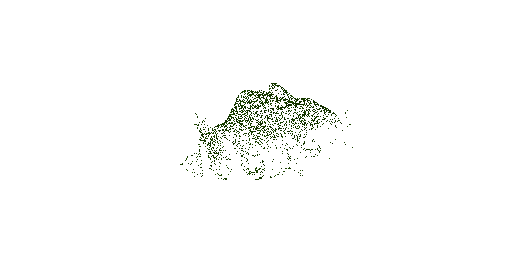

In [105]:
imshow(pth)
plt.axis("off")

In [84]:
global_linear_model = local_models.TLS_models.LinearODR_mD(2)
global_linear_model.fit(data)

In [131]:
global_params_mean = global_linear_model.intercept_

global_linear_vecs = global_linear_model.cov_eigenvectors[global_linear_model.cov_eigenvalues_sorter]
#basis_changer = np.linalg.inv(global_linear_vecs)
basis_changer = global_linear_vecs.T

In [137]:
E = np.block([[global_linear_vecs, global_params_mean.reshape(-1,1)],[np.zeros(3),1]])

In [143]:
np.round(E,4)[np.triu_indices(4)]

array([ 3.245000e-01, -9.006000e-01, -2.893000e-01, -7.171990e+01,
       -3.355000e-01, -1.200000e-02, -3.404612e+02,  9.572000e-01,
        3.103620e+01,  1.000000e+00])

In [132]:
bases_changed = (data-global_params_mean)@basis_changer

In [133]:
x,y,z = bases_changed.T

(-187.96908482736046,
 160.59789562862187,
 -131.1847875447362,
 174.8299866686088)

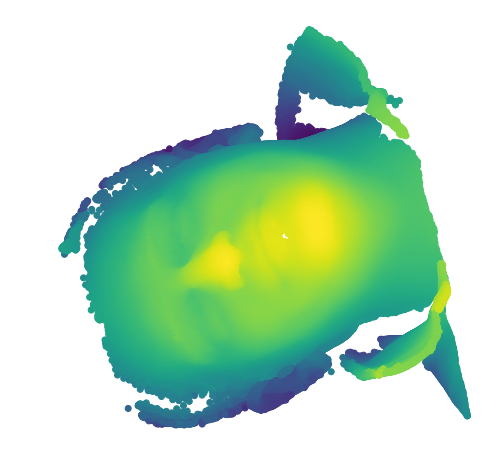

In [134]:
plt.scatter(x,y,c=z)
plt.axis("off")